## Pareto Front - пример визуализации для высокой размерности

В предыдущем посте я писал про [оптимальные по Парето множества](/pareto-front), именуемые также Парето-фронтами.

Для двумерного случая их [рисуют в виде дуги](https://google.com/search?q=pareto+front&tbm=isch), что позволяет визуально сопоставить варианты и принять решение.

Но как быть, когда размерность высокая? Об этом и поговорим.

### Задачка

Есть 2 аргумента и 3 целевые функции. Хочется найти:
- такие минимальные аргументы, с которыми
- первая цель максимизируется,
- а вторая и третья минимизируются.

Смотрите, какая хитрая формулировка: критерии оптимальности накладываются и на целевые функции, и на параметры. То есть по сути здесь 5 факторов.

<!--more-->

Я заготовил кое-какие демонстрационные данные:

In [1]:
import numpy as np

input = np.genfromtxt('data/5d-in.tsv')
print(input)


[[ 4.    1.5  29.34  0.89  2.  ]
 [ 3.    2.    8.36  0.1   3.  ]
 [ 2.    2.5  -5.61  2.08  4.  ]
 ...
 [ 4.    1.   28.18  0.8   4.  ]
 [ 3.4   1.1  13.61  0.59  4.  ]
 [ 4.1   1.   28.18  0.8   4.  ]]


Две колонки слева - аргументы, а три правые - вычисленные для них значения целевых функций. При этом все пять являются факторами для оптимизации.

### Вычисляем Pareto Front

Будем использовать код, написанный в [прошлый раз](/pareto-front). Я его вынес в [отдельный файл](https://github.com/AlekseyMartynov/notebooks/blob/-/notebooks/shared/pareto_front_finder.py) и оформил в виде класса.

In [2]:
from shared.pareto_front_finder import ParetoFrontFinder


Как и в прошлый раз, инвертируем некоторые колонки, чтобы вся оптимизация выражалась в терминах максимумов:

In [3]:
input = np.array([
    [-i[0], -i[1], i[2], -i[3], -i[4]] for i in input
])

print(input)


[[-4.   -1.5  29.34 -0.89 -2.  ]
 [-3.   -2.    8.36 -0.1  -3.  ]
 [-2.   -2.5  -5.61 -2.08 -4.  ]
 ...
 [-4.   -1.   28.18 -0.8  -4.  ]
 [-3.4  -1.1  13.61 -0.59 -4.  ]
 [-4.1  -1.   28.18 -0.8  -4.  ]]


Отправляем всё в `ParetoFrontFinder`:

In [4]:
finder = ParetoFrontFinder()

for i in input:
    finder.push(i)

print(len(finder.front), 'of', len(input))


114 of 861


Осталось более сотни вариантов. Что дальше с ними делать?

### Вариант визуализации

Хотелось бы оценить ситуацию графически. Нарисовать в лоб можно было бы в случае двух или трёх измерений. С тремя уже сложновато ориентироваться в пространстве. А здесь целых пять.

Можно изобразить различные срезы. Например, я придумал вывести [тепловые карты](https://ru.wikipedia.org/wiki/Тепловая_карта) для каждой целевой функции с наложенными на них аргументами:

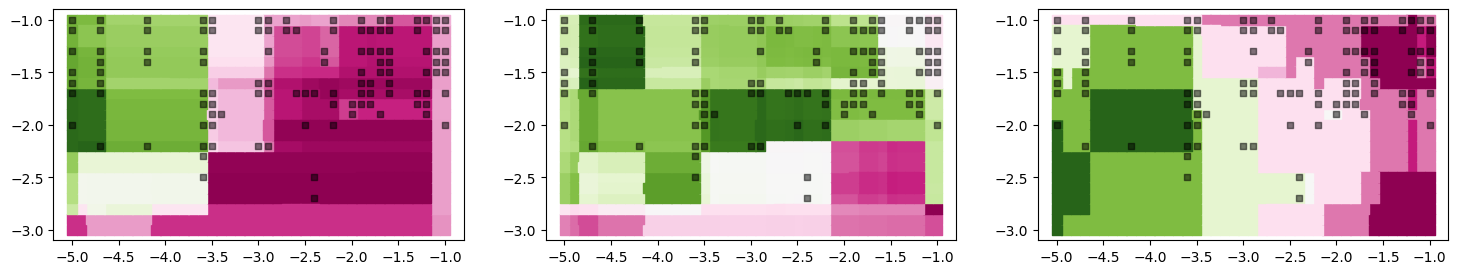

In [5]:
from matplotlib import pyplot as plt

# Оборачиваем в numpy.array для простоты вычленения отдельных колонок
front = np.array(finder.front)


def plot_heatmaps():
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 3)

    for func_index in [0, 1, 2]:

        ax[func_index].scatter(
            input[:, 0], input[:, 1],
            marker='s', s=48,
            c=input[:, func_index + 2], cmap='PiYG'
        )

        ax[func_index].scatter(
            front[:, 0], front[:, 1],
            marker='s', s=16,
            c='black', alpha=0.5
        )

    plt.show()


plot_heatmaps()


Что сказать, красивые рисунки.

Насыщенно-зелёным цветом заполнены области максимума, в которые нам желательно попасть. Тёмные маркеры - аргументы, вошедшие в Pareto-фронт.

Видно, что левая и средняя карты находятся в конфликте. Поэтому возникает нехитрая мысль оставаться в пределах зелёной области на левом рисунке. Для этого достаточно ограничить первый аргумент значением -3.5

In [6]:
predicate_index = front[:, 0] < -3.5
front = front[predicate_index]

len(front)


30

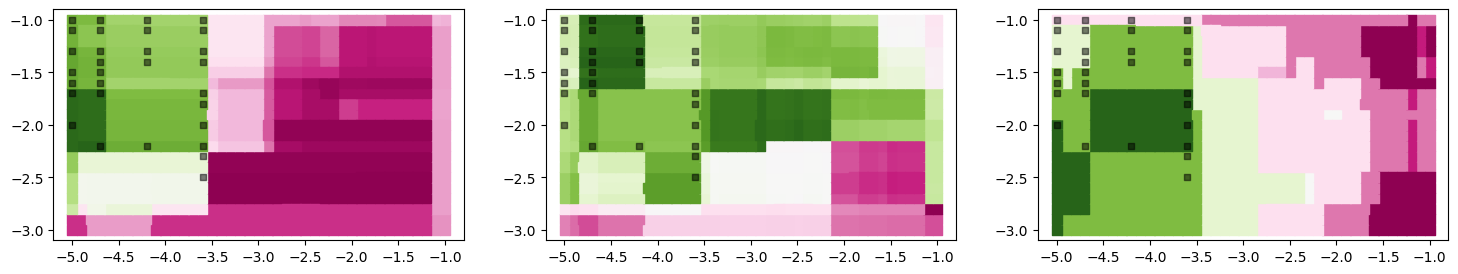

In [7]:
plot_heatmaps()


Ну вот! Осталось 30 вариантов и графически они выглядят вполне удовлетворительно. Значит мы достигли неплохого прогресса.

Сохраним результаты на случай дальнейших исследований и будем прощаться, пока всё не испортили.

In [8]:
np.savetxt('data/5d-out-full.tsv', finder.front, delimiter='\t', fmt='%g')
np.savetxt('data/5d-out-filtered.tsv', front, delimiter='\t', fmt='%g')
